# Transfer Learning

> 이미 학습을 한 모델을 이용하여 모델링을 하는 방법   

모델을 학습시키려면, 많은 데이터, 시간, 돈, 노력 등이 필요하며, 이런 조건들을 갖추고 있는 회사는 많지 않다.   
검증(신뢰)된 `Transfer Learning(전이학습)` 모델들을 제공함으로써 좀더 쉽게 모델링을 할 수 있도록 도와준다.


## 초기 세팅

In [2]:
from google.colab import drive
drive.mount('/content/data')

Mounted at /content/data


In [6]:
import sys

sys.path.append("/content/data/MyDrive/dev/2.deep learning/3. Vision/")

In [7]:
sys.path

['/content',
 '/env/python',
 '/usr/lib/python39.zip',
 '/usr/lib/python3.9',
 '/usr/lib/python3.9/lib-dynload',
 '',
 '/usr/local/lib/python3.9/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.9/dist-packages/IPython/extensions',
 '/root/.ipython',
 '/content/data/MyDrive/dev/2.deep learning/3. Vision/']

In [8]:
from service import data_setup, engine

## torch, torchvision

In [3]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

torch version: 1.13.1+cu116
torchvision version: 0.14.1+cu116


## torchinfo, matplotlib

In [4]:
#Continue with regular imports
import matplotlib.pyplot as plt
import torch 
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it
try:
  from torchinfo import summary
except:
  print("[INFO] Couldn't find torchinfo.....installing it.")
  !pip install -q torchinfo
  from torchinfo import summary

[INFO] Couldn't find torchinfo.....installing it.


## device

In [9]:
# Setupi device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [12]:
try:
  print('aaaa')
except:
  print('bbbb')
else:
  print('cccc')
finally:
  print('dddd')

aaaa
cccc
dddd


# 1.Get data
> pizza, steak, sushi 이미지 데이터

In [18]:
# Setup Dirs
default_path = '/content/data/MyDrive/dev/2.deep learning/3. Vision/data/pizza_steak_sushi'
train_dir = default_path+ "/train"
test_dir = default_path+ "/test"

In [17]:
train_dir

'/content/data/MyDrive/dev/2.deep learning/3. Vision/data/pizza_steak_sushitrain'

# 2.Datasets and DataLoaders

## transform (manual creation)

All pre-trained models expect input images normalized in the same way, i.e. mini-batches of 3-channel RGB images of shape (3 x H x W), where H and W are expected to be at least 224.

The images have to be loaded in to a range of `[0, 1]` and then normalized using mean = `[0.485, 0.456, 0.406]` and std = `[0.229, 0.224, 0.225]`.

In [15]:
manual_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
                         std=[0.229, 0.224, 0.225])
])

In [19]:
# Create training and testing DataLoaders as well as get a list of class names
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=manual_transforms, # resize, convert images to between 0 & 1 and normalize them
                                                                               batch_size=32) # set mini-batch size to 32

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7f402f1bbb80>,
 ['pizza', 'steak', 'sushi'])

## transform (auto creation)
> 전이학습 모델을 사용할 때 가장 중요한 것은 전이학습 모델에서 사용한 데이터와 추가 학습에 사용할 데이터의 모양이 같아야 한다.   

`torchvision v0.13+`에서는 [전이학습 모델의 weights](https://pytorch.org/vision/main/models.html)를 고를 수 있다. 

In [20]:
# Get a set of pretained model weights
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [21]:
# Get the transforms used to create our pretained weights
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [22]:
# Create training and testing DataLoaders as well as get a list of class names
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=auto_transforms, # perform same data transforms on our own data as the pretrained model
                                                                               batch_size=32) # set mini-batch size to 32

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7f402f10ec10>,
 ['pizza', 'steak', 'sushi'])

# 3.Pretained Model

## 전이학습 모델을 고르는 기준
> 일반적으로 전이학습 모델명의 숫자가 클 수록 더 성능은 뛰어나지만, 무거운 모델이라고 생각하면 된다.    

> 따라서 작업해야 하는 컴퓨터 파워를 생각해서 가장 알맞는 전이학습 모델을 선택하는 것이 좋은 방법이다. 

## What is EfficientNet?
> 한정된 자원으로 최대의 효율을 내기 위한 방법으로 model scaling(depth, width, resolution)의 크기를 조절합니다.      
> 기존에는 이 세 가지를 수동으로 조절하였다면, EfficientNet은 model scaling 방법으로 compound scaling 방법을 제안하였습니다.      
> 이 방법을 통해 기존 ConvNet보다 8.4배 작으면서, 6.1배 빠르고 더 높은 정확도를 갖습니다.

## 전이학습 모델 세팅

In [23]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model = torchvision.models.efficientnet_b0(weights=weights).to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-3dd342df.pth


  0%|          | 0.00/20.5M [00:00<?, ?B/s]

In [24]:
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

torchvision.models.efficientnet_b0에 대한 설명
- `features`: A collection of layers
- `avgpool`: features layers의 결과값을 평균하여 feature vector로 변환
- `classifier`: feature vector를 최종 결과를 나타내는 output classes vector로 변환

# Summary

- `col_names`: summary 결과를 제공하는 컬럼명
- `col_width`: summary 결과 너비

In [26]:
summary(model=model,
        input_size=(32, 3, 224, 224),
        col_names = ["input_size", "output_size"])

Layer (type:depth-idx)                                  Input Shape               Output Shape
EfficientNet                                            [32, 3, 224, 224]         [32, 3]
├─Sequential: 1-1                                       [32, 3, 224, 224]         [32, 1280, 7, 7]
│    └─Conv2dNormActivation: 2-1                        [32, 3, 224, 224]         [32, 32, 112, 112]
│    │    └─Conv2d: 3-1                                 [32, 3, 224, 224]         [32, 32, 112, 112]
│    │    └─BatchNorm2d: 3-2                            [32, 32, 112, 112]        [32, 32, 112, 112]
│    │    └─SiLU: 3-3                                   [32, 32, 112, 112]        [32, 32, 112, 112]
│    └─Sequential: 2-2                                  [32, 32, 112, 112]        [32, 16, 112, 112]
│    │    └─MBConv: 3-4                                 [32, 32, 112, 112]        [32, 16, 112, 112]
│    └─Sequential: 2-3                                  [32, 16, 112, 112]        [32, 24, 56, 56]
│    │    └

## output layer 변경
> 학습용 layers들은 고정을하여 더 이상 학습을 하지 않도록 하고, 마지막 결과를 내보내는 output layer만 추가 학습을 시켜 변경시키는 방법     

> The process of transfer learning usually goes: freeze some base layers of a pretrained model(typicall the `features` section) and then adjust the output layers (also called head/classifier layers) to suit your needs.

features의 layers는 더이상 학습을 하지 않도록 고정

In [27]:
# Freeze all base layers in the "features" section of the model(the feature extractor) by setting requires_grad=False
for param in model.features.parameters():
  param.requires_grad = False

기존 `classifier`는 1000개의 사물을 구분하게 하는 로직이다. 

```python
(classifier): Sequential(
    (0): Dropout(p=0.2, inplace=True)
    (1): Linear(in_features=1280, out_features=1000, bias=True)
```

이것을 pizza, steak, sushi를 구분할 수있게 수정하고 학습을 시키면 된다.

In [28]:
# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device
model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True), 
    torch.nn.Linear(in_features=1280, 
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)).to(device)

summary를 이용하여 classifier가 올바르게 변경되었는지 확인해보자.

In [29]:
# # Do a summary *after* freezing the features and changing the output classifier layer (uncomment for actual output)
summary(model, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

Let's go through them:
- `Trainable column`: feature layers는 변경되지 않고 학습에 대한 부분만(requires_grad=False) 변경되었다.  
- `Output shape of classifier`: 결과 모양이 `[32, 1000]`에서 `[32, 3]`으로 변경되었다. 또한 학습을 진행하는 것으로 표현되어 있다.
- `Less trainable parameter`: 기존 학습용 파라미터 수가 5,288,548에서 4,007,548로 줄어들었다. 

# 4.Train model

In [30]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [32]:
# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Setup training and save the results
results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=5,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0977 | train_acc: 0.3828 | test_loss: 0.8725 | test_acc: 0.7225
Epoch: 2 | train_loss: 0.8703 | train_acc: 0.7812 | test_loss: 0.7731 | test_acc: 0.8456
Epoch: 3 | train_loss: 0.8145 | train_acc: 0.7031 | test_loss: 0.7206 | test_acc: 0.8163
Epoch: 4 | train_loss: 0.7041 | train_acc: 0.7617 | test_loss: 0.5957 | test_acc: 0.8864
Epoch: 5 | train_loss: 0.6082 | train_acc: 0.7500 | test_loss: 0.5924 | test_acc: 0.9167
[INFO] Total training time: 205.237 seconds


#5. Evaluate model by plotting loss

In [33]:
def plot_loss_curves(results):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    
    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot 
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

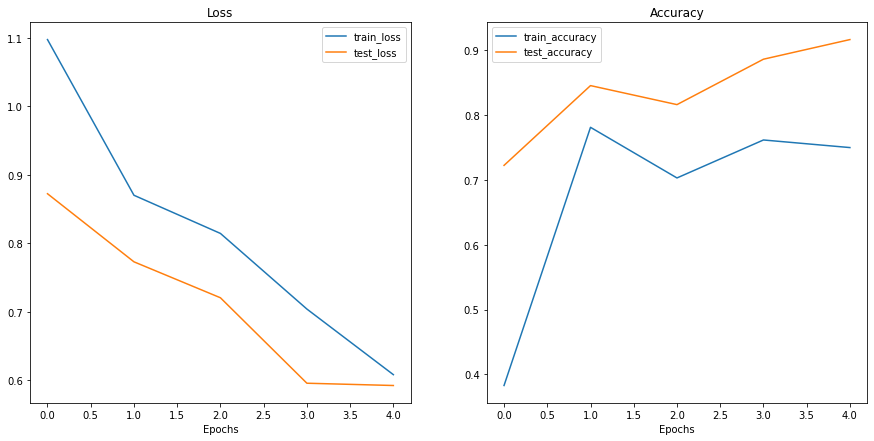

In [35]:
# Plot the loss curves of out model
plot_loss_curves(results)

# 6. Make predictions on images 